# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
from pathlib import Path

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy import fftpack
import torch
import pandas as pd
import zipfile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')
import vtk
from vtk.util import numpy_support as vn

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
from alens_analysis import cluster_analysis as cla

# Locations

/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_48233/510595696.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


torch device: cpu


In [2]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.1'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

# Functions

In [4]:
def monoExp(x, m, a):
    return m * np.exp(-a * x)

def negmonoExp(x, m, a):
    return m*(1. - np.exp(-a * x))

def line_func(x, a, b):
    return a*x + b

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM
def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def func_powerlaw_zero(x, a, b, c):
    return b * np.power(x,c)

def rsqr_val(func, x, y, popts):
    residuals = y - func(x, *popts)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1. - (ss_res / ss_tot)

In [5]:
def spot_msd(tcom_arr, device='cpu'):
    # tcom_arr = torch.from_numpy(com_arr).to(device)
    tcom_arr -= tcom_arr.mean(axis=0)
    Ttot = com_arr.shape[0]
    tvec_mat = tcom_arr[:, None, :] - tcom_arr[None, :, :]
    print(tvec_mat.shape)
    tsqr_mat = torch.einsum('ijk,ijk->ij', tvec_mat, tvec_mat)
    msd = torch.zeros(Ttot, device=device)
    sem = torch.zeros(Ttot, device=device)
    for t in range(Ttot):
        msd[t] = tsqr_mat.diag(t).mean()
        sem[t] = tsqr_mat.diag(t).std()/np.sqrt(tsqr_mat.diag(t).shape[0])


    return msd, sem


# Read data

In [11]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200129_DMSO_P2.xlsx'
data = pd.read_excel(data_path, sheet_name='surface1', header=1).dropna(axis=1, how='any')
data

,Frame,sec,X,Y,Z,X1-X2,Y1-Y2,Z1-Z2,(X1-X2)^2,(Y1-Y2)^2,...,SUM,SQRT,X1-X2.1,Y1-Y2.1,Z1-Z2.1,(X1-X2)^2.1,(Y1-Y2)^2.1,(Z1-Z2)^2.1,SUM.1,SQRT.1
0,1,0.000000,-194.19,-6136.21,21.03,0.00,0.00,0.00,0.0000,0.0000,...,0.0000,0.000000,0.00,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000000
1,2,100.153000,-193.71,-6137.58,22.43,0.48,-1.37,1.40,0.2304,1.8769,...,4.0673,2.016755,0.48,-1.37,1.40,0.2304,1.8769,1.9600,4.0673,2.016755
2,3,200.147003,-193.41,-6137.55,21.48,0.78,-1.34,0.45,0.6084,1.7956,...,2.6065,1.614466,0.30,0.03,-0.95,0.0900,0.0009,0.9025,0.9934,0.996695
3,4,300.157013,-192.81,-6138.45,22.63,1.38,-2.24,1.60,1.9044,5.0176,...,9.4820,3.079286,0.60,-0.90,1.15,0.3600,0.8100,1.3225,2.4925,1.578765
4,5,400.088013,-193.64,-6138.35,22.56,0.55,-2.14,1.53,0.3025,4.5796,...,7.2230,2.687564,-0.83,0.10,-0.07,0.6889,0.0100,0.0049,0.7038,0.838928


torch.Size([51, 51, 3])
torch.Size([51, 51, 3])
torch.Size([51, 51, 3])
torch.Size([48, 48, 3])
torch.Size([51, 51, 3])
torch.Size([45, 45, 3])


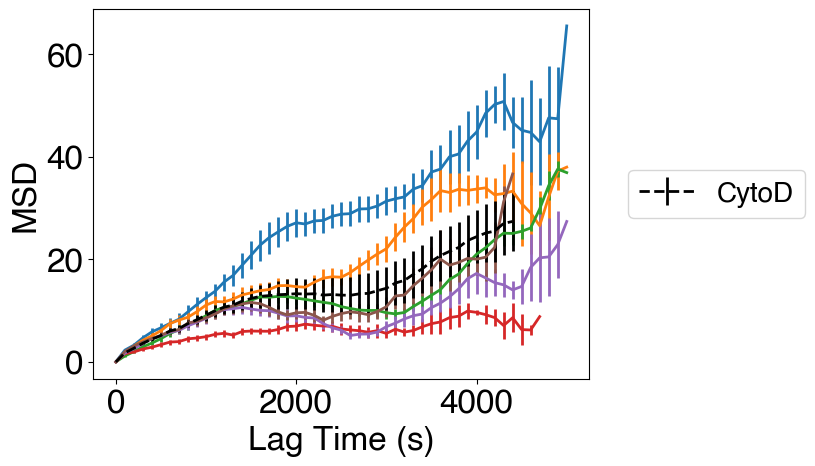

In [64]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200129_DMSO_P2.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5', 'surface6']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

# _ = plt.yscale('log')
# _ = plt.xscale('log')

torch.Size([51, 51, 3])
torch.Size([51, 51, 3])
torch.Size([51, 51, 3])
torch.Size([48, 48, 3])
torch.Size([51, 51, 3])
torch.Size([45, 45, 3])


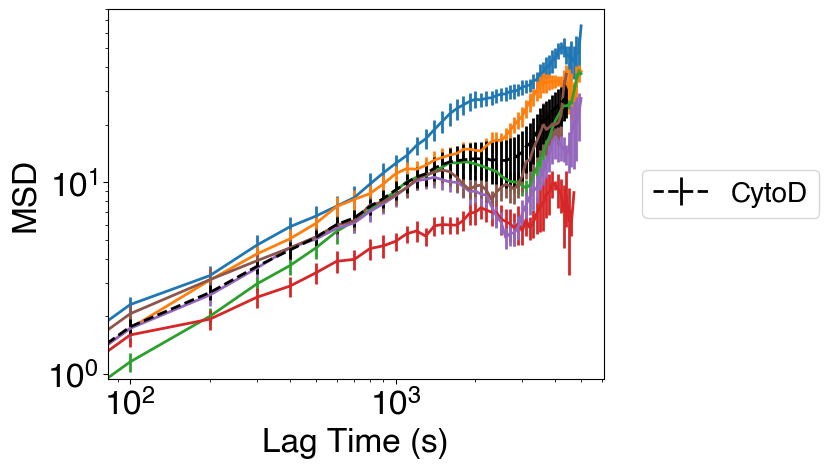

In [65]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200129_DMSO_P2.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5', 'surface6']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([51, 51, 3])
torch.Size([51, 51, 3])
torch.Size([51, 51, 3])
torch.Size([51, 51, 3])


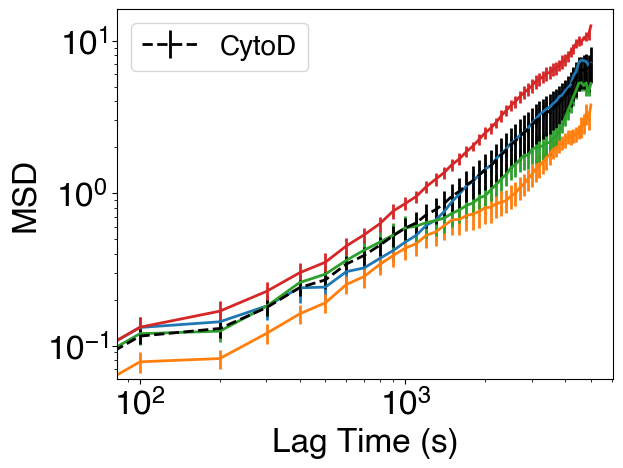

In [66]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200129_CytoD_P5.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_cyto = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_cyto[:], msd_arr, yerr=std_arr)

msd_avg_cyto = torch.stack(msd_list).mean(dim=0)
sem_avg_cyto = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_cyto[:], msd_avg_cyto, yerr=sem_avg_cyto, label='CytoD', color='k', linestyle='--')        

# _ = plt.plot(time_arr[:], msd_arr, color='tab:orange')
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend()
_ = plt.yscale('log')
_ = plt.xscale('log')
# _ = plt.loglog(time_arr[1:], corr_avg, color='tab:orange')

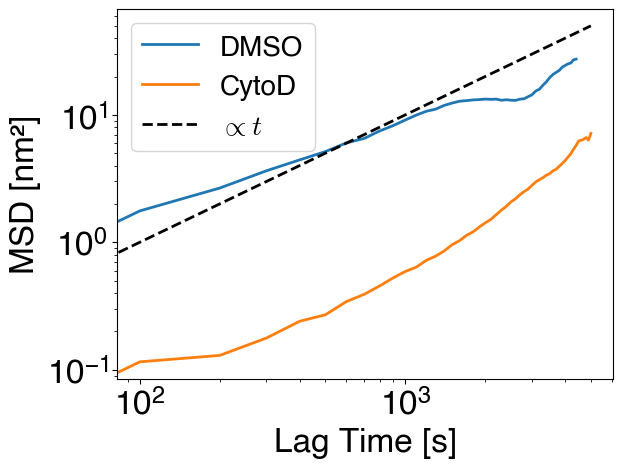

In [51]:
_ = plt.plot(time_arr_dmso[:], msd_avg_dmso, label='DMSO', color='tab:blue')
_ = plt.plot(time_arr_cyto[:], msd_avg_cyto, label='CytoD', color='tab:orange')
_ = plt.plot(time_arr_cyto[:], .01*time_arr_cyto, label=f'$\propto t$', color='k', linestyle='--')

_ = plt.ylabel('MSD [nm²]')
_ = plt.xlabel('Lag Time [s]')
_ = plt.legend()

_ = plt.yscale('log')
j_ = plt.xscale('log')

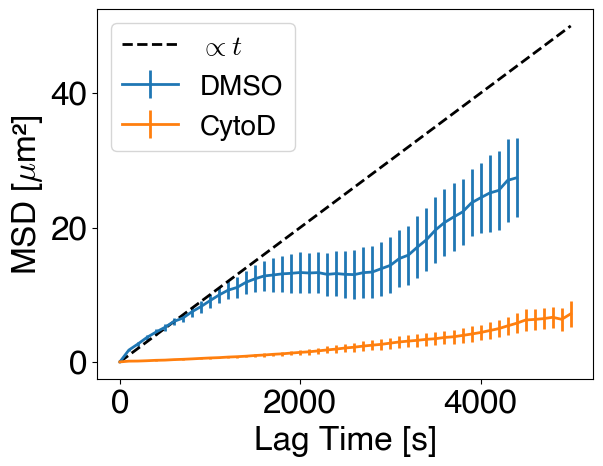

In [69]:
_ = plt.errorbar(time_arr_dmso[:], msd_avg_dmso, yerr=sem_avg_dmso, label='DMSO', color='tab:blue')        
_ = plt.errorbar(time_arr_cyto[:], msd_avg_cyto, yerr=sem_avg_cyto, label='CytoD', color='tab:orange')        
# _ = plt.plot(time_arr_cyto[:], .01*time_arr_cyto, label=f'$\propto t$', color='k', linestyle='--')
_ = plt.plot(time_arr_cyto[:], .01*time_arr_cyto, label=f'$\propto t$', color='k', linestyle='--')

_ = plt.ylabel('MSD [$\mu$m²]')
_ = plt.xlabel('Lag Time [s]')
_ = plt.legend()

# _ = plt.yscale('log')
# _ = plt.xscale('log')

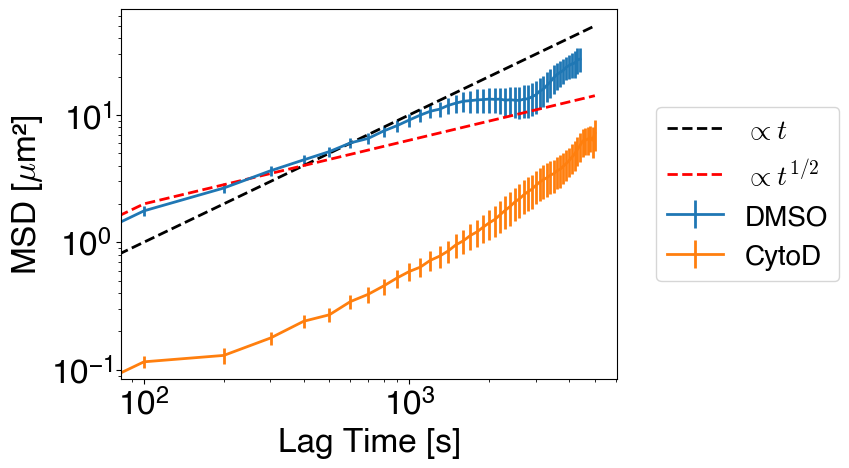

In [77]:
_ = plt.errorbar(time_arr_dmso[:], msd_avg_dmso, yerr=sem_avg_dmso, label='DMSO', color='tab:blue')        
_ = plt.errorbar(time_arr_cyto[:], msd_avg_cyto, yerr=sem_avg_cyto, label='CytoD', color='tab:orange')        
# _ = plt.plot(time_arr_cyto[:], .01*time_arr_cyto, label=f'$\propto t$', color='k', linestyle='--')
_ = plt.plot(time_arr_cyto[:], .01*time_arr_cyto, label=f'$\propto t$', color='k', linestyle='--')
_ = plt.plot(time_arr_cyto[:], .2*np.power(time_arr_cyto, .5), label=f'$\propto t^{{1/2}}$', color='r', linestyle='--')


_ = plt.ylabel('MSD [$\mu$m²]')
_ = plt.xlabel('Lag Time [s]')
_ = plt.legend()
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))


_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([51, 51, 3])
torch.Size([51, 51, 3])
torch.Size([51, 51, 3])
torch.Size([48, 48, 3])
torch.Size([51, 51, 3])


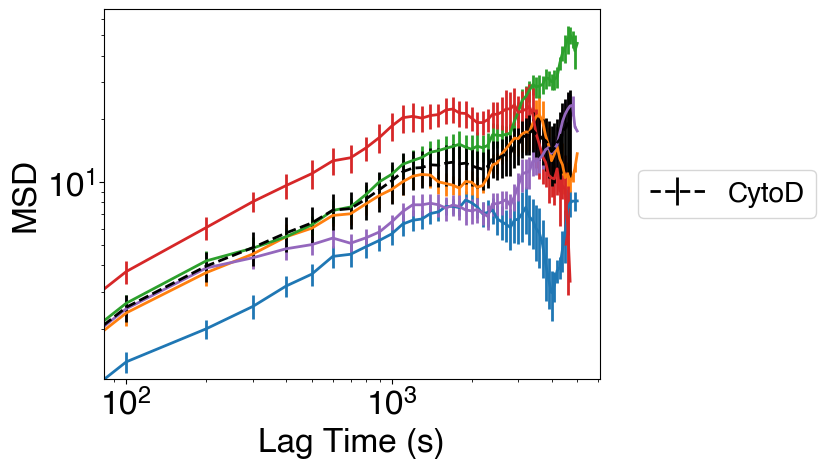

In [80]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200129_DMSO_P4.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


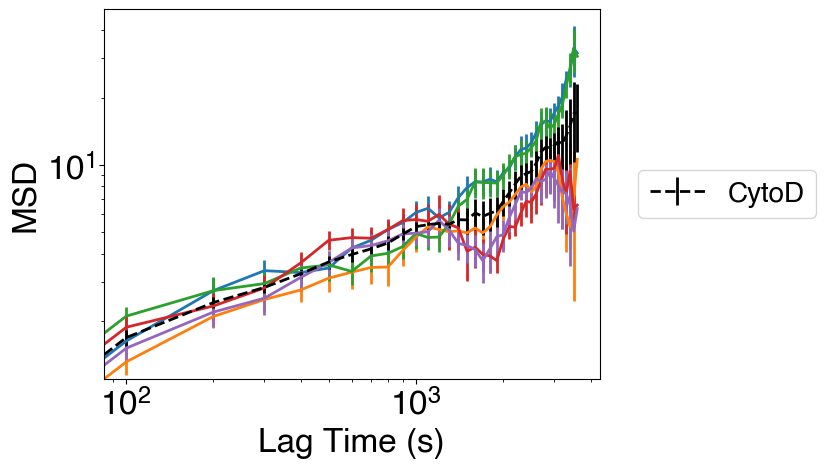

In [81]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200904_DMSO_P2.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


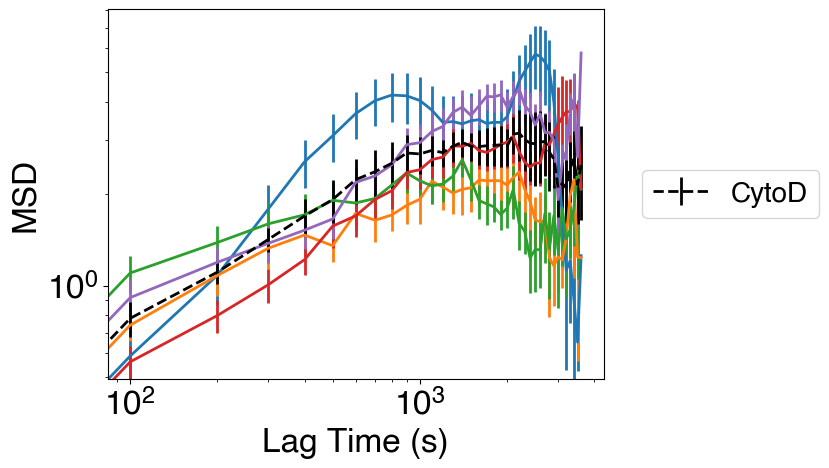

In [82]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200904_DMSO_P3.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


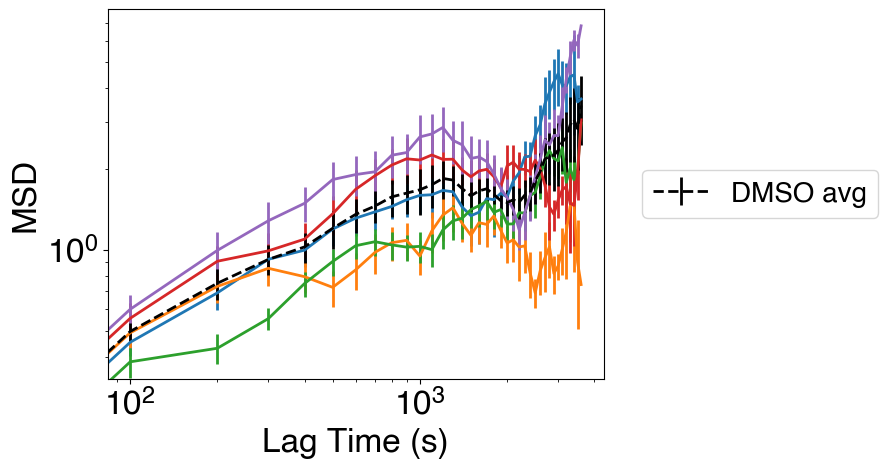

In [93]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200904_DMSO_P1.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='DMSO avg', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


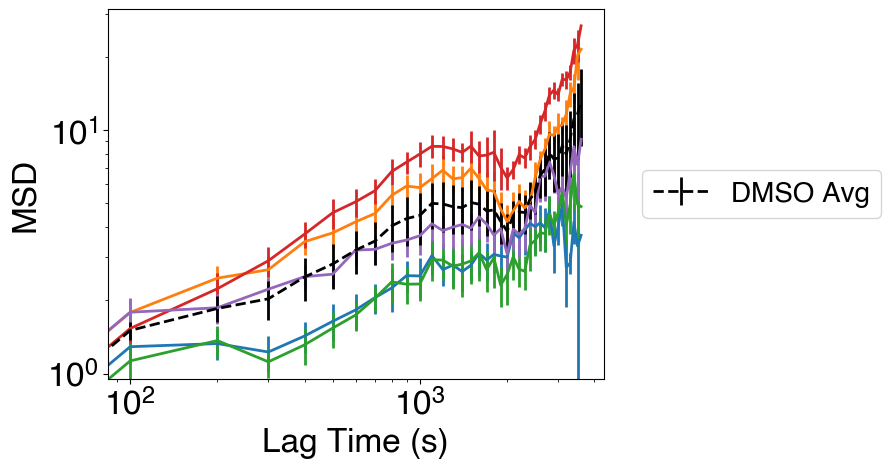

In [91]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200914_DMSO_P1.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='DMSO Avg', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


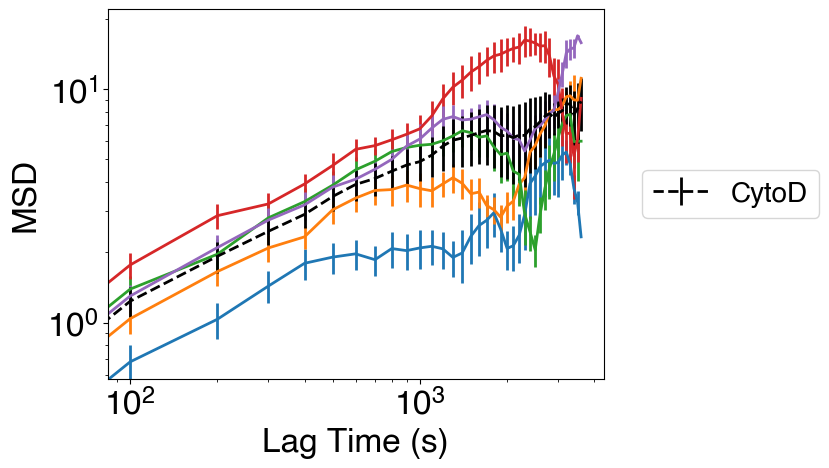

In [85]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200914_DMSO_P2.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


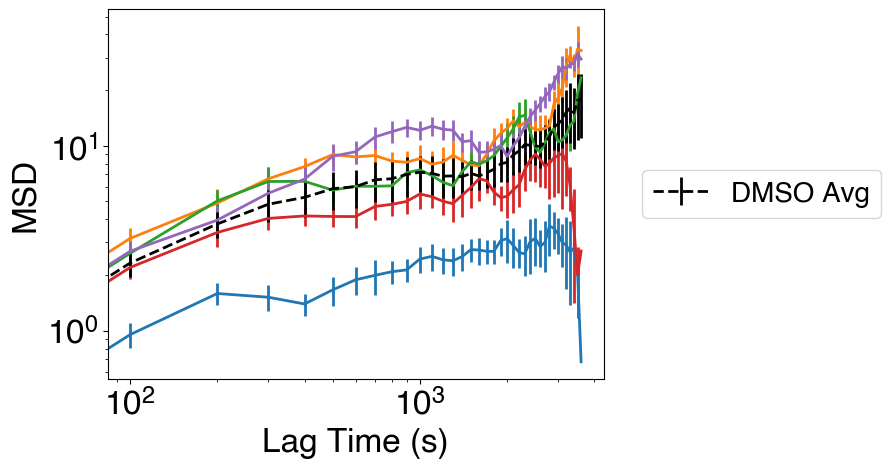

In [92]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200914_DMSO_P3.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='DMSO Avg', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


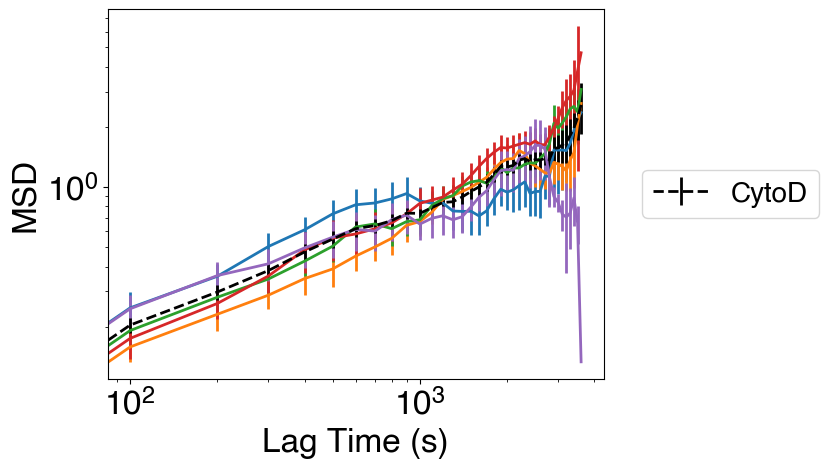

In [87]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200904_CytoD_P6.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


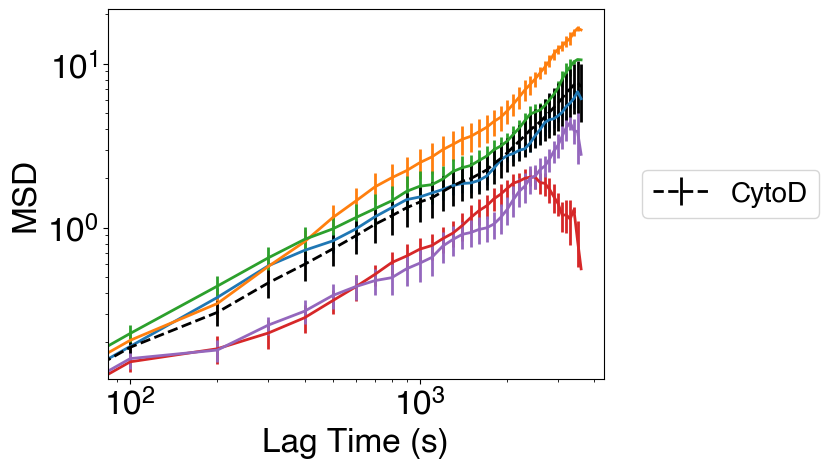

In [88]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200904_CytoD_P7.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')

torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])
torch.Size([37, 37, 3])


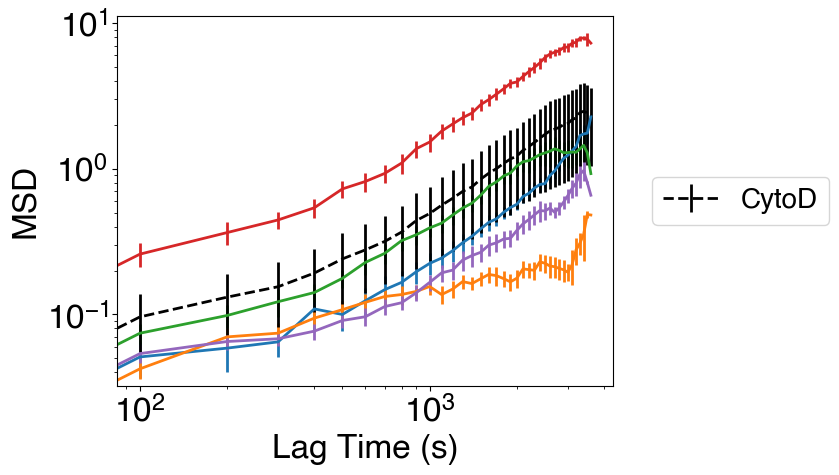

In [89]:
data_path = Path.home() / 'Desktop/Imaris_Raw_Data/200914_CytoD_P8.xlsx'
msd_list = []
for sheet in ['surface1', 'surface2', 'surface3', 'surface4', 'surface5']:
    data = pd.read_excel(data_path, sheet_name=sheet, header=1).dropna(axis=1, how='any')
    time_arr_dmso = torch.from_numpy(data['sec'].values[:].astype(np.float64))
    com_arr = torch.from_numpy(data[['X','Y','Z']].values.astype(np.float64))
    msd_arr, std_arr = spot_msd(com_arr, device=device)
    msd_list.append(msd_arr)
    _ = plt.errorbar(time_arr_dmso[:], msd_arr, yerr=std_arr)

# Make all the msd arrays the same length
min_len = min([len(msd) for msd in msd_list])
msd_list = [msd[:min_len] for msd in msd_list]

msd_avg_dmso = torch.stack(msd_list).mean(dim=0)

sem_avg_dmso = torch.stack(msd_list).std(dim=0)/np.sqrt(len(msd_list))
_ = plt.errorbar(time_arr_dmso[:min_len], msd_avg_dmso, yerr=sem_avg_dmso, label='CytoD', color='k', linestyle='--')        
_ = plt.ylabel('MSD')
_ = plt.xlabel('Lag Time (s)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.05, .5))

_ = plt.yscale('log')
_ = plt.xscale('log')